In [ ]:
import pandas as pd

df = pd.read_csv(r"chicago_beach_weather.csv", sep=',', parse_dates=['Measurement Timestamp'])
df = df.pivot(index='Measurement Timestamp', columns='Station Name', values='Air Temperature')

df = df.asfreq('H')
df = df.interpolate()

C:\Users\fcogneaux\AppData\Local\Temp\2\ipykernel_29804\2784684669.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(r"chicago_beach_weather.nan.csv", sep=',', parse_dates=['Measurement Timestamp'])


In [4]:
df

Station Name,63rd Street Weather Station,Foster Weather Station,Oak Street Weather Station
Measurement Timestamp,,,
2016-01-01 00:00:00,-2.8,-3.67,-2.3
2016-01-01 01:00:00,-3.5,-4.56,-3.2
2016-01-01 02:00:00,-4.2,-5.50,-4.0
2016-01-01 03:00:00,-5.1,-6.28,-4.8
2016-01-01 04:00:00,-5.7,-7.00,-5.5
...,...,...,...
2016-12-31 19:00:00,0.7,0.06,1.3
2016-12-31 20:00:00,0.2,-0.28,0.9
2016-12-31 21:00:00,-0.2,-0.67,0.6


c:\Users\fcogneaux\AppData\Local\miniconda3\envs\Darts\lib\site-packages\darts\timeseries.py:4870: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
c:\Users\fcogneaux\AppData\Local\miniconda3\envs\Darts\lib\site-packages\darts\timeseries.py:4870: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
c:\Users\fcogneaux\AppData\Local\miniconda3\envs\Darts\lib\site-packages\darts\timeseries.py:4870: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


<Axes: xlabel='Measurement Timestamp'>

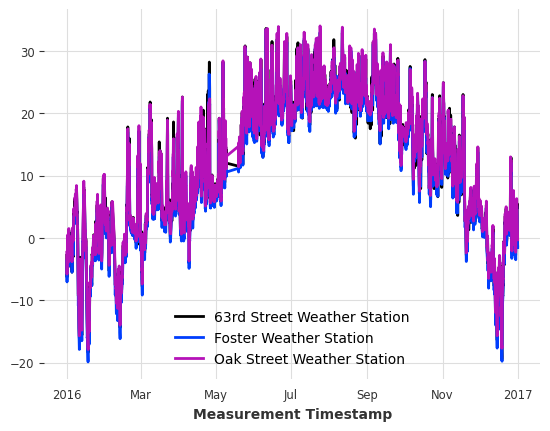

In [ ]:
import numpy as np
from darts import TimeSeries

tf_63rd = TimeSeries.from_series(df["63rd Street Weather Station"]).astype(np.float32)
tf_63rd.plot()
tf_Foster = TimeSeries.from_series(df["Foster Weather Station"]).astype(np.float32)
tf_Foster.plot()
tf_Oak = TimeSeries.from_series(df["Oak Street Weather Station"], fill_missing_dates=True, freq="H").astype(np.float32)
tf_Oak.plot()


In [7]:
from pandas import Timestamp

tf_63rd_train, tf_63rd_val = tf_63rd.split_before(Timestamp("2016-12-01"))
tf_Foster_train, tf_Foster_val = tf_Foster.split_before(Timestamp("2016-12-01"))
tf_Oak_train, tf_Oak_val = tf_Oak.split_before(Timestamp("2016-12-01"))


In [20]:
from pytorch_lightning.callbacks import EarlyStopping
from darts.models import TFTModel
from torch.optim.lr_scheduler import ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=False
)

model = TFTModel(
    input_chunk_length=24 * 7,
    output_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopping], "precision": "32-true"},
    add_relative_index=True,
        lr_scheduler_cls=ReduceLROnPlateau,
        lr_scheduler_kwargs={
            "monitor": "val_loss",
            "factor": 0.5,
            "patience": 5,
            "mode": "min",
            "verbose": True
        }
)

model.fit(
    series=[tf_63rd_train, tf_Foster_train, tf_Oak_train],
    val_series=[tf_63rd_val, tf_Foster_val, tf_Oak_val],
    epochs=50,
    verbose=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528    | train
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K  | train
7  | static_cont

Epoch 49: 100%|██████████| 738/738 [00:41<00:00, 17.95it/s, train_loss=3.060, val_loss=2.380]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 738/738 [00:41<00:00, 17.95it/s, train_loss=3.060, val_loss=2.380]


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=1, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000214F870FA90>], 'precision': '32-true'}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'monitor': 'val_loss', 'factor': 0.5, 'patience': 5, 'mode': 'min', 'verbose': True})

In [21]:
tf_backtest = model.historical_forecasts(
    series=[tf_63rd_val, tf_Foster_val, tf_Oak_val],
    forecast_horizon=1,
    stride=1,
    last_points_only=True,
    retrain=False,
    verbose=True,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 54/54 [00:06<00:00,  8.82it/s]


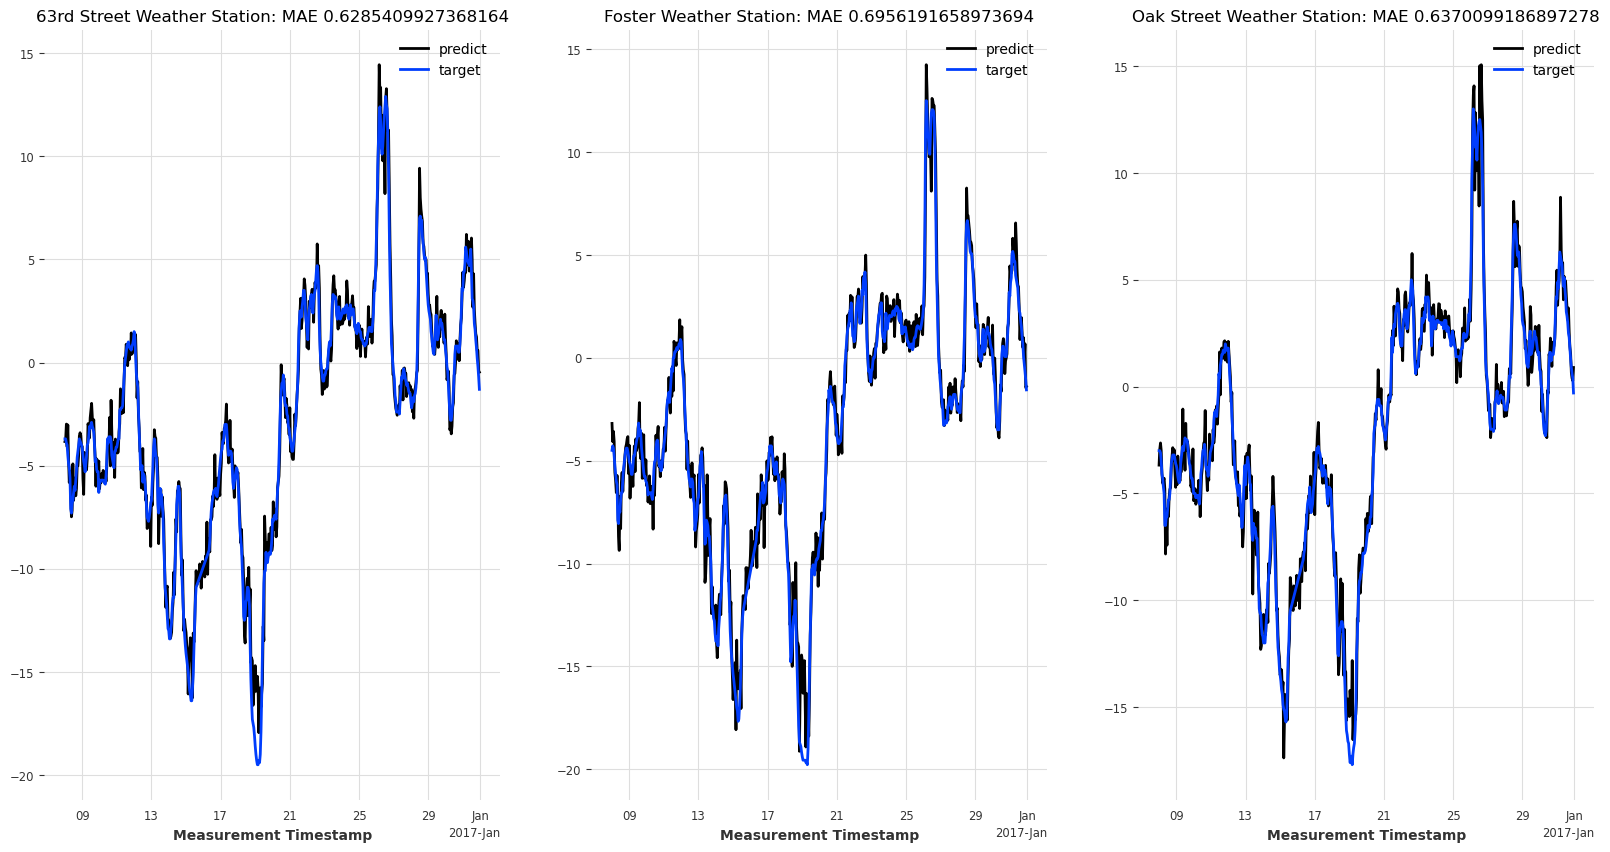

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

tf_backtest[0].plot(label='predict', ax=ax1)
tf_63rd_val.slice_intersect(tf_backtest[0]).plot(label='target', ax=ax1)
ax1.set_title(f"{tf_backtest[0].columns[0]}: MAE {mae(tf_backtest[0], tf_63rd_val)}")

tf_backtest[1].plot(label='predict', ax=ax2)
tf_Foster_val.slice_intersect(tf_backtest[1]).plot(label='target', ax=ax2)
ax2.set_title(f"{tf_backtest[1].columns[0]}: MAE {mae(tf_backtest[1], tf_Foster_val)}")

tf_backtest[2].plot(label='predict', ax=ax3)
tf_Oak_val.slice_intersect(tf_backtest[2]).plot(label='target', ax=ax3)
ax3.set_title(f"{tf_backtest[2].columns[0]}: MAE {mae(tf_backtest[2], tf_Oak_val)}")

plt.show()
